In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [22]:
class ReadImage():
    def __init__(self, image_path):
        self.image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        self.bisecting_line = None
        self.slope = None
        self.intercept = None

    def get_bisecting_line(self):
        region_1 = (self.image == 51).astype(np.uint8)
        contours, _ = cv2.findContours(region_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cornea_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(cornea_contour)
        if M["m00"] != 0:
            cx_up = int(M["m10"] / M["m00"]) 
            cy_up = int(M["m01"] / M["m00"]) 
        else:
            cx_up, cy_up = 0, 0

        region_2 = (self.image == 153).astype(np.uint8) 
        contours, _ = cv2.findContours(region_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cornea_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(cornea_contour)
        if M["m00"] != 0:
            cx_lo = int(M["m10"] / M["m00"]) 
            cy_lo = int(M["m01"] / M["m00"]) 
        else:
            cx_lo, cy_lo = 0, 0

        x_centers = [cx_up, cx_lo]
        y_centers = [cy_up, cy_lo]
        m, b = np.polyfit(x_centers, y_centers, 1)
        x_values = np.array([0, self.image.shape[1]])  # Dynamic x range based on image width
        y_values = m * x_values + b
        self.slope = m
        self.intercept = b
        self.bisecting_line = [x_values, y_values]

        return self.bisecting_line

    def density_center(self):
        tolerance = 50
        
        x_values = self.bisecting_line[0]  
        y_values = self.bisecting_line[1]

        tear_film = (self.image == 102).astype(np.uint8)
        highlighted_image = tear_film.copy()
        
        intersection_points = []
        white_region_coords = np.column_stack(np.where(tear_film > 0))

        for point in white_region_coords:
            x, y = point[1], point[0]
            y_line = self.slope * x + self.intercept
            if abs(y - y_line) <= tolerance:
                intersection_points.append((x, y))
                highlighted_image[y, x] = 255

        print(len(intersection_points))

        if len(intersection_points) > 0:
            center_point = intersection_points[len(intersection_points) // 2]
            center_x, center_y = center_point

            region_width = 100  # Adjust

            left_x = center_x
            right_x = center_x

            while left_x > 0 and tear_film[center_y, left_x] > 0 and (center_x - left_x) <= region_width:
                highlighted_image[center_y, left_x] = 255
                left_x -= 1

            while right_x < highlighted_image.shape[1] and tear_film[center_y, right_x] > 0 and (right_x - center_x) <= region_width:
                highlighted_image[center_y, right_x] = 255 
                right_x += 1

        center_highlight = [[left_x, right_x], [center_y, center_y]]

        highlighted_region = tear_film[center_y, left_x:right_x+1]
        white_pixels = np.sum(highlighted_region == 1) 
        total_pixels = highlighted_region.size 
        density = white_pixels / total_pixels if total_pixels > 0 else 0

        return density, center_highlight

    def density_edge_left(self):
        tear_film = (self.image == 102).astype(np.uint8) * 255  
        blurred_tear_film = cv2.GaussianBlur(tear_film, (5, 5), 0)
        edges = cv2.Canny(blurred_tear_film, threshold1=50, threshold2=150)
        
        tolerance = 100 
        height, width = edges.shape
        left_edge_x = None
        for x in range(width):
            if np.any(edges[:, x] > 0):
                left_edge_x = x
                break
                
        left_edge_y = None
        for y in range(height):
            if np.any(edges[y, :] > 0):
                left_edge_y = y
                break

        bottom_left_x = left_edge_x
        bottom_left_y = left_edge_y
        
        bottom_right_x = min(left_edge_x + tolerance, width)  
        bottom_right_y = bottom_left_y  
        
        up_left_x = bottom_left_x
        up_left_y = min(left_edge_y + tolerance, height) 
        
        up_right_x = bottom_right_x
        up_right_y = up_left_y

        left_box_region = edges[bottom_left_y:up_left_y, bottom_left_x:bottom_right_x]

        return left_box_region, bottom_left_x, bottom_left_y

    def density_edge_right(self):
        tear_film = (self.image == 102).astype(np.uint8) * 255  
        blurred_tear_film = cv2.GaussianBlur(tear_film, (5, 5), 0)
        edges = cv2.Canny(blurred_tear_film, threshold1=50, threshold2=150)
        
        tolerance = 100 
        height, width = edges.shape

        right_edge_x = None
        for x in range(width - 1, -1, -1):
            if np.any(edges[:, x] > 0):  
                right_edge_x = x
                break
                
        right_edge_y = None
        for y in range(height):
            if np.any(edges[y, right_edge_x] > 0):
                right_edge_y = y
                break

        bottom_right_x = right_edge_x
        bottom_right_y = right_edge_y
        
        bottom_left_x = max(right_edge_x - tolerance, 0)
        bottom_left_y = right_edge_y

        up_right_x = bottom_right_x
        up_right_y = min(right_edge_y + tolerance, height)

        up_left_x = bottom_left_x
        up_left_y = up_right_y 

        right_box_region = edges[bottom_left_y:up_left_y, bottom_left_x:bottom_right_x]

        return right_box_region, bottom_right_x, bottom_right_y

    def plot_bisecting_line(self):
        x_values, y_values = self.bisecting_line
        plt.imshow(self.image, cmap='gray')
        plt.ylim(self.image.shape[0], 0)
        plt.plot(x_values, y_values, color='blue', linestyle='-', label='Line passing through centers')
        plt.ylim(500, 0)
        plt.title('Cornea with Bisecting Line')
        plt.show()

    def plot_center_density(self, center_highlight):
        plt.imshow(self.image, cmap='gray')
        plt.plot(center_highlight[0], center_highlight[1], color='red', linewidth=2)
        plt.title("Center Density Highlight")
        plt.show()

    def plot_edge_box_left(self, left_box_region, top_left_x, top_left_y):
        plt.imshow(self.image, cmap='gray')

        box_height, box_width = left_box_region.shape
        for y in range(box_height):
            for x in range(box_width):
                if left_box_region[y, x] > 0:  # Non-black (edge) pixel
                    plt.scatter(top_left_x + x, top_left_y + y, color='yellow', s=1)  # Scatter plot in yellow
    
        plt.title("Image with Left Box Region Edges Highlighted")
        plt.show()
        

    def plot_edge_box_right(self, right_box_region, bottom_right_x, bottom_right_y):
        plt.imshow(self.image, cmap='gray')
        box_height, box_width = right_box_region.shape
        for y in range(box_height):
            for x in range(box_width):
                if right_box_region[y, x] > 0:  # Non-black (edge) pixel
                    plt.scatter(bottom_right_x - box_width + x, bottom_right_y + y, color='red', s=1)

        plt.title("Image with right Box Region Edges Highlighted")
        plt.show()

    def plot_all(self, center_highlight, left_box, right_box):
        self.plot_bisecting_line()
        self.plot_center_density(center_highlight)
        self.plot_edge_boxes(left_box, right_box)


In [23]:
img1 = ReadImage('SCL_OCT_dataset/label/CKY_OD_1H_img005_outcome.png')
line = img1.get_bisecting_line()

In [24]:
center_density, center_highlight = img1.density_center()

51


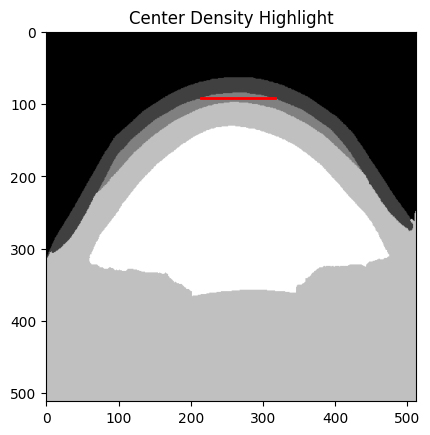

In [25]:
img1.plot_center_density(center_highlight)

In [26]:
left_box_region, xl, yl = img1.density_edge_left()
right_box_region, xr, yr = img1.density_edge_right()

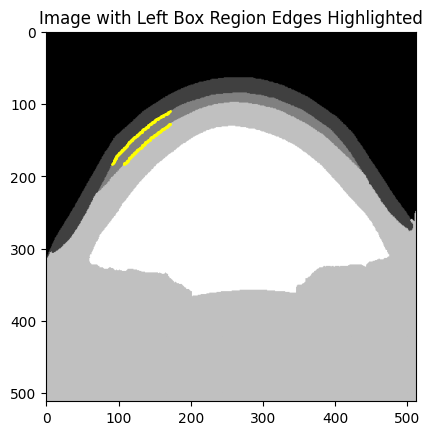

In [27]:
img1.plot_edge_box_left(left_box_region, xl, yl)

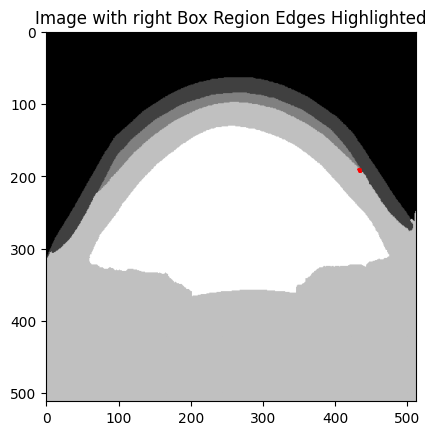

In [28]:
img1.plot_edge_box_right(right_box_region, xr, yr)